<a href="https://colab.research.google.com/github/vncs16/Rede_neural_Convolucional/blob/main/Rede_Neural_convolucional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# DEBUG
print(IN_COLAB)

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

True
Mounted at /content/drive


In [ ]:
import os
import random
import time
import platform

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
import torch.nn.functional as F
from torch import nn, optim
# import torch.nn as nn
# import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import transforms, models, datasets, utils

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# Verifica se a GPU está disponível
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('\nDevice: {0}'.format(DEVICE))


Device: cuda


In [ ]:
!nvidia-smi

Thu Nov 30 00:06:17 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if IN_COLAB:
    ds_path_val = '/content/drive/My Drive/Data/Dataset/Test/'
    ds_path_test = '/content/drive/My Drive/Data/Dataset/Train/'
else:
    ds_path = 'data/flowers-recognition/flowers/'

In [ ]:
# Número de classes
num_classes = 2

# Nomes das classes
class_names = ['Defective', 'Non-Defective']

# Tamanho do lote (mini-batch)
batch_size = 64

# Taxa de aprendizado
lr = 0.001

# Mommentum
mm = 0.9

# Número de épocas
epochs = 50 # Usar durante o desenvolvimento
### epochs = 50

In [ ]:
# Treinamento
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    ### transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    # Média e desvio padrão do ImageNet.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(ds_path_test, transform=data_transforms)
val_dataset = datasets.ImageFolder(ds_path_val, transform=data_transforms)

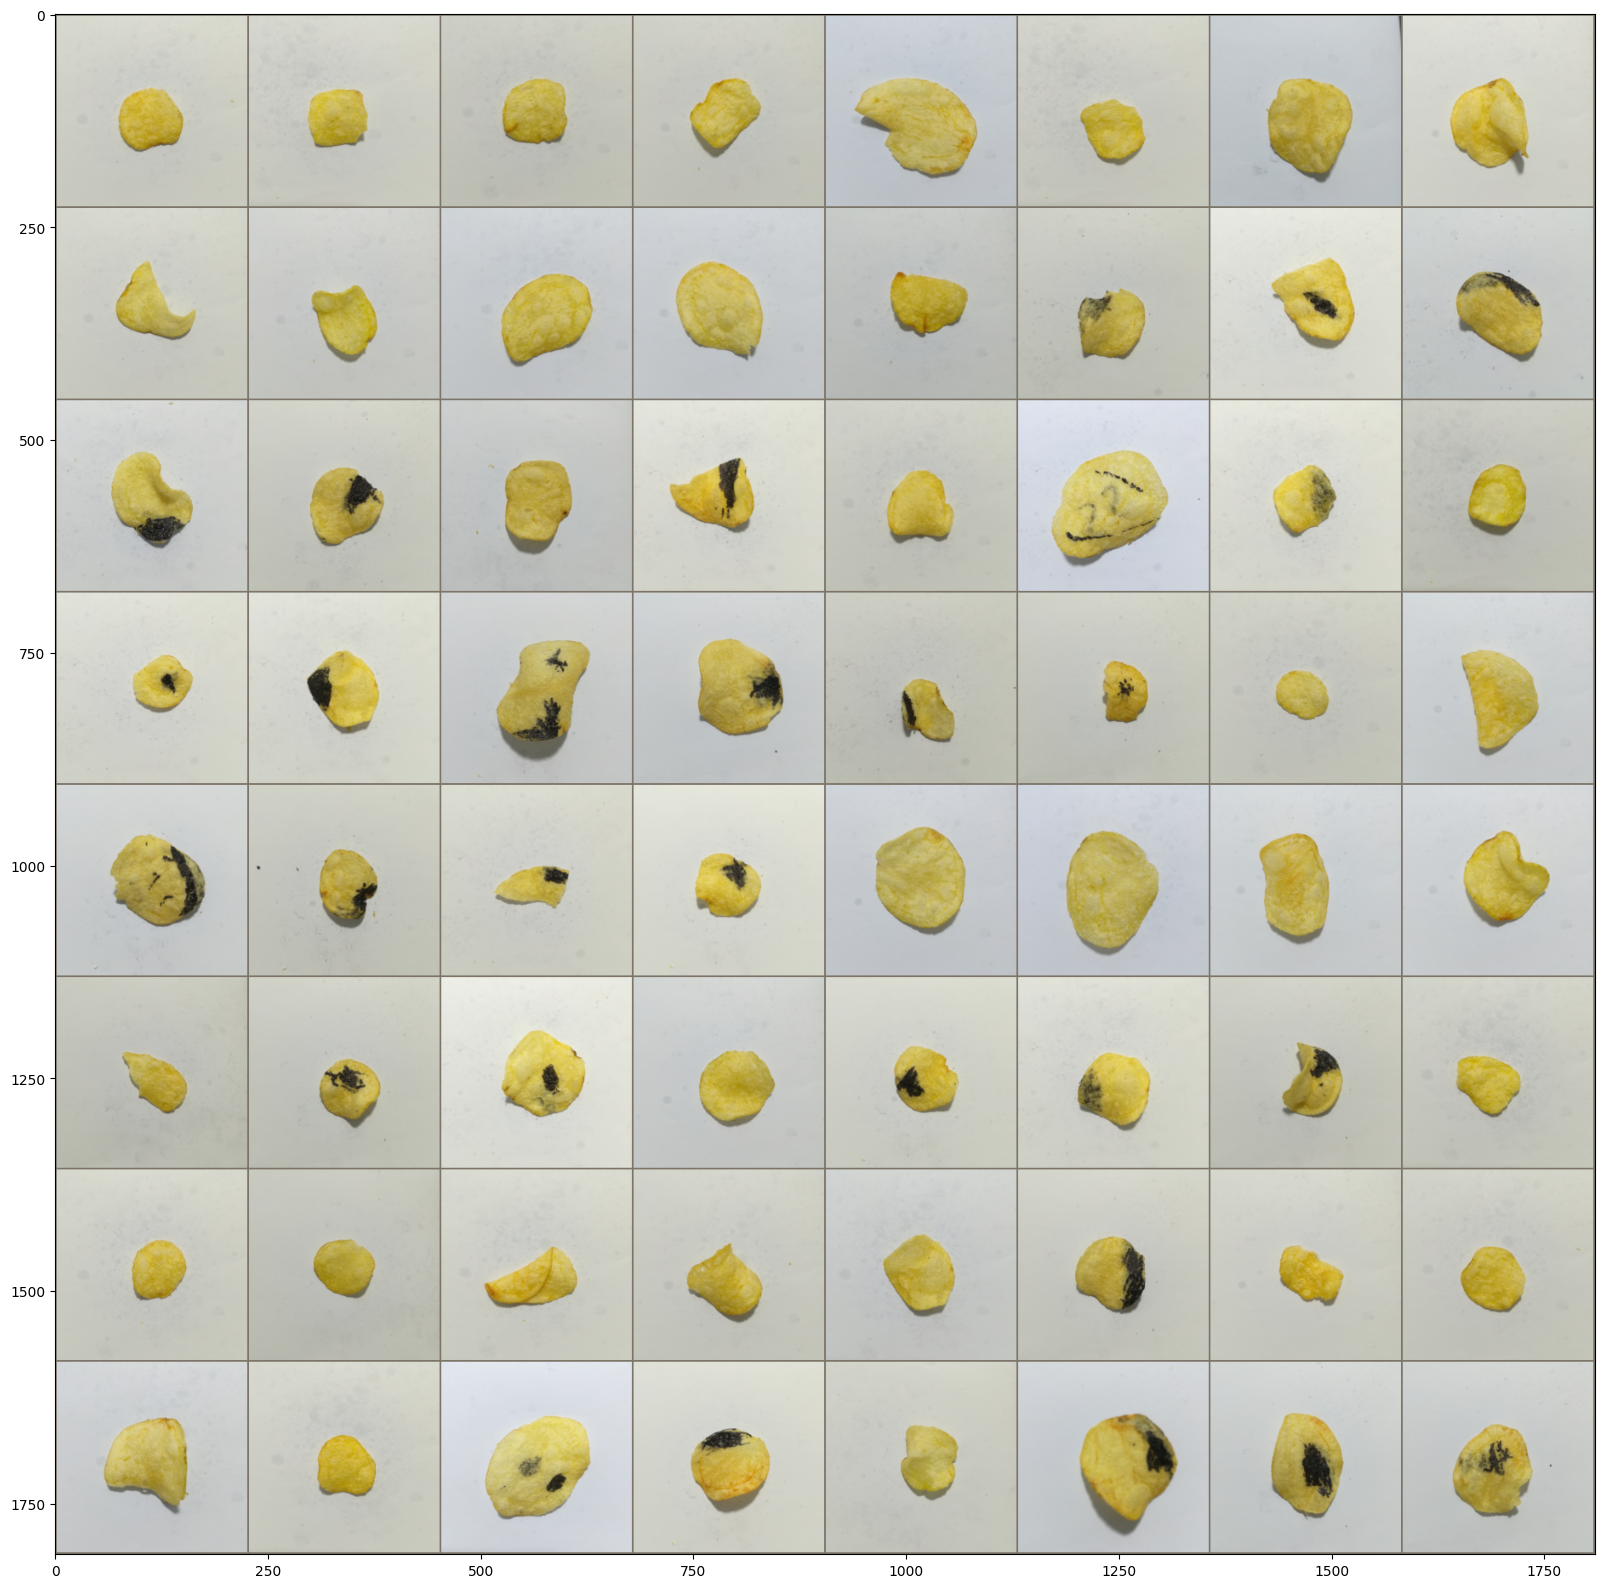

In [ ]:
def show_transformed_image(image):
    # Unnormalize all channels
    ### for t, m, s in zip(np_image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
    for t, m, s in zip(image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]): # (ImageNet weights)
        t.mul_(s).add_(m)

    np_image = image.numpy()

    plt.figure(figsize=(20, 20))
    plt.imshow(np.transpose(np_image, (1, 2, 0)))

# Visualizar 'batch_size' imagens
dataloader_vis = torch.utils.data.DataLoader(dataset=train_dataset, shuffle=True, batch_size=64)
items = iter(dataloader_vis)
image, label = next(items)

show_transformed_image(utils.make_grid(image))

In [ ]:
# Conjunto de treinamento: 80 %
#train_size = len(dataset_train)
# Conjunto de validação: 20 %
#test_size = len(dataset_test)

# Spliting the full dataset
#train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
# Número de imagens em cada dataset
train_size = len(train_dataset)
val_size = len(val_dataset)

# DEBUG
print(train_size)
print(val_size)

# Definindo os dataloaders
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size)

769
192


In [ ]:
class Net(nn.Module):
    """
    Consider each image having 32 rowns by 32 columns.
    Input [3, 32, 32]
    Conv1(3, 6, 5) [6, 28, 28]
    Pool(2, 2) [6, 14, 14]
    Conv2(6, 16, 5) [16, 10, 10]
    Pool(2, 2) [16, 5, 5]
    Flatten [400]
    Fc1 [120]
    Fc2 [84]
    Fc3 [10]
    """

    def __init__(self, in_channels, num_classes):
        """
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        torch.nn.MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)
        """
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        """
        Consider each image having 32 rowns by 32 columns.
        """
        # conv1(x): Input: [32, 32, 3]. Output: [28, 28, 6].
        #   Como padding=0 e kernel_size=5, a imagem é "reduzida" 2 linhas (5-1/2 = 2) acima e abaixo e 2 colunas à esquerda e à direita.
        # pool: Input: [28, 28, 6], Output: [14, 14, 6]
        x = self.pool(F.relu(self.conv1(x)))
        # conv2: Input: [14, 14, 6]. Output: [10, 10, 16].
        #   Como padding=0 e kernel_size=5, a imagem é "reduzida" 2 linhas (5-1/2 = 2) acima e abaixo e 2 colunas à esquerda e à direita.
        # pool: Input: [10, 10, 16], Output: [5, 5, 16]
        x = self.pool(F.relu(self.conv2(x)))
        # flatten: Input: [5, 5, 16]. Output: [400]
        x = torch.flatten(x, 1)
        # fc1: Input: [400]. Output: [120]
        x = F.relu(self.fc1(x))
        # fc2: Input: [120]. Output: [80]
        x = F.relu(self.fc2(x))
        # fc3: Input: [80]. Output: [num_classes]
        x = self.fc3(x)
        return x

In [ ]:
### model_ft = models.alexnet(pretrained=True)
model_ft = models.alexnet(weights='AlexNet_Weights.DEFAULT')

# Altera o número de neurônios na cadama de saída.
model_ft.classifier[6] = nn.Linear(4096, num_classes)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 106MB/s]


In [ ]:

model_ft = models.googlenet(weights='GoogLeNet_Weights.DEFAULT')

# Altera o número de neurônios na cadama de saída.
model_ft.fc = nn.Linear(1024, num_classes)

In [ ]:
# Simple net
### model = Net(3, 5)

# Pretrainned
model = model_ft

In [ ]:
# Envia o modelo para a GPU
if DEVICE.type == 'cuda':
    model = model.cuda() # Cuda

# Imprime o modelo
print(str(model))

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [ ]:
# Função de perda
criterion = nn.CrossEntropyLoss()

# Otimizador
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=mm)

In [ ]:
# Tempo total do treinamento (treinamento e validação)
time_total_start = time.time()

# Lista das perdas (loss) e acurácias (accuracy) de trino para cada época.
train_loss_list = []
train_acc_list = []

# Lista das perdas (loss) e acurácias (accuracy) de validação para cada época.
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    # TREINAMENTO
    # =========================================================================
    # Inicia contagem de tempo da época
    time_epoch_start = time.time()

    # Habilita o modelo para o modo de treino
    model.train()

    # Perda (loss) nesta época
    loss_epoch_train = 0.0
    # Amostras classificadas corretamente nesta época
    num_hits_epoch_train = 0

    # Iterate along the batches of the TRAINING SET
    for inputs, labels in train_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # FORWARD
        # ------>
        # Habilita o cálculo do gradiente
        torch.set_grad_enabled(True)

        # Saída do modelo para o lote
        outputs = model(inputs)

        # 'outputs' está em porcentagens. Tomar os maximos como resposta.
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # BACKWARD
        # <-------
        loss.backward()

        # Atualiza os parâmetros da rede
        optimizer.step()

        # Atualiza a perda da época
        loss_epoch_train += float(loss.item()) * inputs.size(0)

        # Atualiza o número de amostras classificadas corretamente na época.
        num_hits_epoch_train += torch.sum(preds == labels.data)

    # Perda desta época
    train_loss = loss_epoch_train / train_size
    # Acurácia desta época
    train_acc = float(num_hits_epoch_train.double() / train_size)

    # Store loss and accuracy in lists
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # VALIDAÇÃO
    # =========================================================================
    model.eval()

    # Pego o numero de perda e o numero de acertos
    loss_epoch_val = 0.0 # Atual perda
    num_hits_epoch_val = 0 # Numero de itens corretos

    # Iterate along the batches of the VALIDATION SET
    for inputs, labels in val_dataloader:

        if DEVICE.type == 'cuda':
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

        # Zera os parametros do gradiente
        optimizer.zero_grad()

        # Desabilita o cálculo do gradiente durante a validação.
        torch.set_grad_enabled(False)

        # Gero um tensor cujas linhas representam o tamanho do "batch" do input
        outputs = model(inputs)

        # Retorna a maior predicao.
        #### _, preds = torch.max(outputs, 1)
        preds = torch.argmax(outputs, dim=1).float()

        # Calcula a perda (loss)
        loss = criterion(outputs, labels)

        # Atualiza a perda da época
        loss_epoch_val += float(loss.item()) * inputs.size(0)
        # # Atualiza os acertos da época
        num_hits_epoch_val += torch.sum(preds == labels.data)

    # Ajusta o learning rate
    ### scheduler.step()

    # Perda e acuracia do conjunto de validacao para esta época
    val_loss = loss_epoch_val / val_size
    val_acc = float(num_hits_epoch_val.double() / val_size)

    # Store loss and accuracy in lists
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Tempo total desta época
    time_epoch = time.time() - time_epoch_start

    # PRINTING
    # --------
    print('Epoch {}/{} - TRAIN Loss: {:.4f} TRAIN Acc: {:.4f} - VAL. Loss: {:.4f} VAL. Acc: {:.4f} ({:.4f} seconds)'.format(epoch, epochs - 1, train_loss, train_acc, val_loss, val_acc, time_epoch))

# Tempo total do treinamento
time_total_train = time.time() - time_total_start

# PRINTING
print('\nTreinamento finalizado. ({0}m and {1}s)'.format(int(time_total_train // 60), int(time_total_train % 60)))

Epoch 0/49 - TRAIN Loss: 1.0249 TRAIN Acc: 0.4629 - VAL. Loss: 0.8135 VAL. Acc: 0.5208 (991.8775 seconds)
Epoch 1/49 - TRAIN Loss: 1.1801 TRAIN Acc: 0.4083 - VAL. Loss: 0.6646 VAL. Acc: 0.5208 (102.0591 seconds)
Epoch 2/49 - TRAIN Loss: 1.0487 TRAIN Acc: 0.1352 - VAL. Loss: 0.6566 VAL. Acc: 0.5208 (104.9727 seconds)
Epoch 3/49 - TRAIN Loss: 1.0114 TRAIN Acc: 0.2263 - VAL. Loss: 0.6382 VAL. Acc: 0.5208 (102.5159 seconds)
Epoch 4/49 - TRAIN Loss: 1.0133 TRAIN Acc: 0.1456 - VAL. Loss: 0.6138 VAL. Acc: 0.5208 (103.3085 seconds)
Epoch 5/49 - TRAIN Loss: 0.9853 TRAIN Acc: 0.1964 - VAL. Loss: 0.5980 VAL. Acc: 0.5208 (101.2707 seconds)
Epoch 6/49 - TRAIN Loss: 0.9798 TRAIN Acc: 0.1717 - VAL. Loss: 0.5890 VAL. Acc: 0.5260 (100.9107 seconds)
Epoch 7/49 - TRAIN Loss: 0.9722 TRAIN Acc: 0.2081 - VAL. Loss: 0.5784 VAL. Acc: 0.5365 (104.2272 seconds)
Epoch 8/49 - TRAIN Loss: 0.9526 TRAIN Acc: 0.2211 - VAL. Loss: 0.5594 VAL. Acc: 0.5365 (103.1763 seconds)
Epoch 9/49 - TRAIN Loss: 0.9203 TRAIN Acc: 0.2

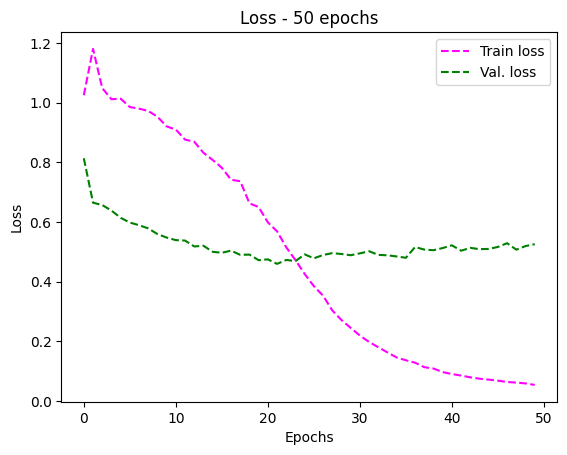

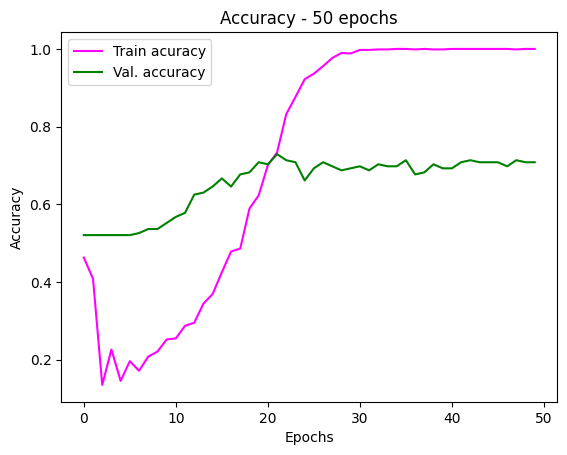

In [ ]:
# Lista com os indices das épocas. [0, 1, ... num_epochs - 1]
epochs_list = []
for i in range(len(train_loss_list)):
    epochs_list.append(i)

# Titulo - Loss and accuracy chart
loss_title = 'Loss - ' + str(epochs) + ' epochs'
acc_title = 'Accuracy - ' + str(epochs) + ' epochs'

# Plot - Loss
plt.figure()
plt.title(loss_title)
plt.plot(epochs_list, train_loss_list, c='magenta' ,ls='--', label='Train loss', fillstyle='none')
plt.plot(epochs_list, val_loss_list, c='green' ,ls='--', label='Val. loss', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best')

# Plot - Accuracy
plt.figure()
plt.title(acc_title)
plt.plot(epochs_list, train_acc_list, c='magenta' ,ls='-', label='Train acuracy', fillstyle='none')
plt.plot(epochs_list, val_acc_list, c='green' ,ls='-', label='Val. accuracy', fillstyle='none')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')

In [ ]:
# Lista com as classes reais e classes preditas
true_val_list = []
pred_val_list = []
# Lista com as probabilidades
prob_val_list = []

# Iterate along the batches of the VALIDATION SET
for i, (img_list, labelList) in enumerate(val_dataloader):

    if DEVICE.type == 'cuda':
        img_list = img_list.to(DEVICE)
        labelList = labelList.to(DEVICE)

    # Desabilita o cálculo do gradiente durante validação e testes.
    torch.set_grad_enabled(False)

    # -----> FORWARD
    # Saída do modelo
    outputs = model(img_list)

    # Predição
    ### _, preds = torch.max(output, 1)
    preds = torch.argmax(outputs, dim=1)

    # Calcula probabilidades
    # https://discuss.pytorch.org/t/obtain-probabilities-from-cross-entropy-loss/157259
    outputs_prob = nn.functional.softmax(outputs, dim=1)
    prob_val_batch = np.asarray(outputs_prob.cpu())

    # Classes reais true) e classes preditas (pred) para este lote.
    if DEVICE.type == 'cuda':
        true_val_batch = np.asarray(labelList.cpu())
        pred_val_batch = np.asarray(preds.cpu())

    # Itera ao longo do lote
    for i in range(0, len(pred_val_batch)):
        true_val_list.append(true_val_batch[i])
        pred_val_list.append(pred_val_batch[i])

        prob_val_list.append(prob_val_batch[i])

In [ ]:
# Confusion matrix
conf_mat_val = metrics.confusion_matrix(true_val_list, pred_val_list)
print('\nConfusion matrix ( validation)')
print(conf_mat_val)

# Classification report - Scikit-learn
class_rep_val = metrics.classification_report(true_val_list, pred_val_list,
                                              target_names=class_names, digits=4,
                                              zero_division=0)
print('\nClass. report (validation)')
print(class_rep_val)

# Accuracy
acc_val = metrics.accuracy_score(true_val_list, pred_val_list)
print('\n\nValidation Acc.: {:.4f}'.format(acc_val))


Confusion matrix ( validation)
[[ 36  56]
 [  0 100]]

Class. report (validation)
               precision    recall  f1-score   support

    Defective     1.0000    0.3913    0.5625        92
Non-Defective     0.6410    1.0000    0.7813       100

     accuracy                         0.7083       192
    macro avg     0.8205    0.6957    0.6719       192
 weighted avg     0.8130    0.7083    0.6764       192



Validation Acc.: 0.7083
